In [10]:
# Load a few packages first 

In [11]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from evaluate_2 import evaluate_2
from unet_2 import UNet_2
from utils.data_loading_2 import BasicDataset_2, CarvanaDataset_2
from utils.loss_calculator import calculate_loss

import time

In [12]:
model = UNet_2(n_channels=1, n_classes=1, bilinear=False)

In [13]:
for tag, value in model.named_parameters():
    histograms = {}
    tag = tag.replace('/', '.')
    print(tag)
    if not (torch.isinf(value) | torch.isnan(value)).any():
        histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
    if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
        histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

inc.double_conv.0.weight


TypeError: isinf(): argument 'input' (position 1) must be Tensor, not NoneType

In [4]:
for tag, value in model.named_parameters():
    histograms = {}
    tag = tag.replace('/', '.')
    print(tag)
    if not (torch.isinf(value) | torch.isnan(value)).any():
        histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
    if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
        histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

inc.double_conv.0.weight


TypeError: isinf(): argument 'input' (position 1) must be Tensor, not NoneType

In [5]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

inc.double_conv.0.weight
inc.double_conv.1.weight
inc.double_conv.1.bias
inc.double_conv.3.weight
inc.double_conv.4.weight
inc.double_conv.4.bias
down1.maxpool_conv.1.double_conv.0.weight
down1.maxpool_conv.1.double_conv.1.weight
down1.maxpool_conv.1.double_conv.1.bias
down1.maxpool_conv.1.double_conv.3.weight
down1.maxpool_conv.1.double_conv.4.weight
down1.maxpool_conv.1.double_conv.4.bias
down2.maxpool_conv.1.double_conv.0.weight
down2.maxpool_conv.1.double_conv.1.weight
down2.maxpool_conv.1.double_conv.1.bias
down2.maxpool_conv.1.double_conv.3.weight
down2.maxpool_conv.1.double_conv.4.weight
down2.maxpool_conv.1.double_conv.4.bias
down3.maxpool_conv.1.double_conv.0.weight
down3.maxpool_conv.1.double_conv.1.weight
down3.maxpool_conv.1.double_conv.1.bias
down3.maxpool_conv.1.double_conv.3.weight
down3.maxpool_conv.1.double_conv.4.weight
down3.maxpool_conv.1.double_conv.4.bias
down4.maxpool_conv.1.double_conv.0.weight
down4.maxpool_conv.1.double_conv.1.weight
down4.maxpool_conv.1.doubl

In [2]:
#dir_img = Path('./data/imgs/')
#dir_mask = Path('./data/masks/')
#dir_checkpoint = Path('./checkpoints/')


dir_img = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/img/'
dir_mask = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/mask/'
dir_D = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-11-13/15-53/Diffusion/'
D_range = [0.01, 1]


In [6]:
dataset = CarvanaDataset_2(dir_img, dir_mask, dir_D, D_range, scale = 1)

100%|██████████| 1000/1000 [01:07<00:00, 14.75it/s]


In [13]:
loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(dataset, shuffle=True, **loader_args)
for batch in train_loader:
    images, true_masks, true_D = batch['image'], batch['mask'], batch['D']
    break 

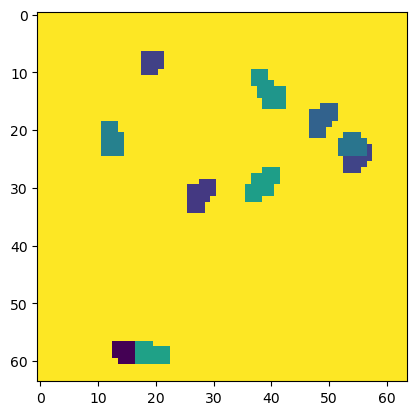

In [15]:
import matplotlib.pyplot as plt
true_D.max()
plt.imshow(true_D[0])

In [1]:
from datetime import datetime
 # Define the base path
base_path = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Evaluation'
# Get current date and time
now = datetime.now()
date_str = now.strftime('%Y-%m-%d')  # Format for date (e.g., '2024-08-26')
time_str = now.strftime('%m-%d_%H-%M')  # Format for time (e.g., '08-26_15-30')

# Create directory paths
date_folder = os.path.join(base_path, date_str)
time_folder = os.path.join(date_folder, time_str)

# Create directories
os.makedirs(time_folder, exist_ok=True)  # exist_ok=True to avoid error if the directory already exists

dir_checkpoint = time_folder
wandb_dir = time_folder

NameError: name 'os' is not defined

In [14]:
def test_train(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-4,
        val_percent: float = 10,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
        wandb_log = False, 
        lr_step_size: int = 10,
        lr_gamma: float = 0.1
):
    
    # 1. Create dataset
    try:
        dataset = CarvanaDataset_2(dir_img, dir_mask, dir_D, D_range, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset_2(dir_img, dir_mask, dir_D, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)
    # (Initialize logging)
    if wandb_log:
        experiment = wandb.init(project='blurry_newSimulation', resume='allow', anonymous='must', dir = wandb_dir)
        experiment.config.update(
            dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                 val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
        )


    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    #criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()

    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()  # Start time
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks, true_D = batch['image'], batch['mask'], batch['D']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)
                true_D = true_D.to(device=device, dtype=torch.float)

                

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    # Calculate the MSE based on the non-zero values
                    masks_pred, diffusion_pred = model(images)
                    loss1,loss2 = calculate_loss(masks_pred.float(),diffusion_pred,true_masks.float(),true_D)  # Using MSE
                    loss = loss1 + loss2
                # Log the losses
                # logging.info(f"Loss1: {loss1.item()}, Loss2: {loss2.item()}")
                #log the loss here. 
                #logging.info(loss2)
                
                #logging.info(diffusion_pred.requires_grad)
                

                # loss.backward(retain_graph=True)

                optimizer.zero_grad(set_to_none=False)

                #loss2.backward()
                #logging.info(diffusion_pred.grad)

                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()

                #logging.info( model.outc_mask.weight.grad)
                
                #logging.info(model.outc_diffusion.weight.grad)

                if wandb_log:
                    experiment.log({
                        'mask_loss': loss1.item(),
                        'Diffusion_loss':loss2.item(),
                        'step': global_step,
                        'epoch': epoch
                    })
                
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        # Evaluate after each epoch
                        avg_loss1, avg_loss2 = evaluate_2(model, val_loader, device, amp)
                        # Log or print the losses
                        logging.info(f'Epoch {epoch}, Loss1: {avg_loss1:.4f}, Loss2: {avg_loss2:.4f}')
                        mask_pred_prob = torch.sigmoid(masks_pred)  # Convert logits to probabilities
                        threshold = 0.5  # Define the threshold
                        binary_mask = (mask_pred_prob >= threshold).float()  # Apply the threshold to get binary mask

                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'images': wandb.Image(images[0].cpu()),
                             'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(binary_mask[0].cpu()),
                            },
                            'diffusion': {
                                'true': wandb.Image(true_D[0].float().cpu()),
                                'pred': wandb.Image(diffusion_pred[0].float().cpu()),
                            },
                            'results': {
                                'true': wandb.Image(true_masks[0].float().cpu()*true_D[0].float().cpu()),  # Combined result of true mask and diffusion
                                 'pred': wandb.Image(binary_mask[0].cpu()*diffusion_pred[0].float().cpu()),  # Combined result of predicted mask and diffusion
                            },
                            'Validation Mask Loss':avg_loss1,
                            'Validation Diffusion Loss': avg_loss2,
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })
        # Update learning rate after each epoch
        scheduler.step()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        if wandb_log:
            experiment.log({'epoch_duration': epoch_duration, 'epoch': epoch})         
            
        if save_checkpoint:
            # Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            # state_dict['mask_values'] = dataset.mask_values
            # Save checkpoint as 'checkpoint_epoch1.pth', 'checkpoint_epoch2.pth', 'checkpoint_epoch3.pth'
            checkpoint_number = (epoch % 3) + 1
            # Convert dir_checkpoint to Path if it's a string
            checkpoint_path = f"{dir_checkpoint}/model_checkpoint_{checkpoint_number}.pth"
            torch.save(state_dict, checkpoint_path)
    
            logging.info(f'Checkpoint for epoch {epoch} saved as checkpoint_epoch{checkpoint_number}.pth!')
            
    return masks_pred, diffusion_pred, true_masks, true_D, images, loss





In [10]:
checkpoint_path = f"{dir_checkpoint}/model_checkpoint_epoch_{3}.pth"

In [15]:
#args = get_args()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet_2(n_channels=3, n_classes=1, bilinear=False)
#model = model.to(memory_format=torch.channels_last)
#checkpoint = torch.load(checkpoint_path)
#model.load_state_dict(checkpoint)
model = model.to(memory_format=torch.channels_last)


logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

model.to(device=device)
try:
    masks_pred, diffusion_pred, true_masks, true_D, images, loss = test_train(
    #masks_pred_bi, masks_pred = test_train(
        model=model,
        epochs=50,
        batch_size=8,
        learning_rate=1e-5,
        device=device,
        img_scale=1.,
        val_percent=0.1,
        amp=False,
        wandb_log = True,
        save_checkpoint= True
    )

except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                    'Enabling checkpointing to reduce memory usage, but this slows down training. '
                    'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=10,
        batch_size=1,
        learning_rate=1e-5,
        device=device,
        img_scale=1,
        val_percent=0.5 / 100,
        amp=False
    )


INFO: Using device cuda
INFO: Network:
	3 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 1000 examples
INFO: Scanning mask files to determine unique values
100%|██████████| 1000/1000 [01:07<00:00, 14.78it/s]
INFO: Unique mask values: [0, 1]
ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dyfan777 (llgroup). Use `wandb login --relogin` to force relogin


INFO: Starting training:
        Epochs:          50
        Batch size:      8
        Learning rate:   1e-05
        Training size:   900
        Validation size: 100
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1.0
        Mixed Precision: False
    
Epoch 1/50:  20%|█▉        | 176/900 [02:46<10:07,  1.19img/s, loss (batch)=0.633]
Validation round: 0batch [00:00, ?batch/s]
Validation round: 1batch [00:22, 22.17s/batch]
Validation round: 2batch [00:27, 12.42s/batch]
Validation round: 3batch [00:34,  9.93s/batch]
Validation round: 4batch [00:41,  8.51s/batch]
Validation round: 5batch [00:47,  7.64s/batch]
Validation round: 6batch [00:54,  7.42s/batch]
Validation round: 7batch [01:01,  7.26s/batch]
Validation round: 8batch [01:07,  6.97s/batch]
Validation round: 9batch [01:13,  6.81s/batch]
Validation round: 10batch [01:20,  6.85s/batch]
Validation round: 11batch [01:27,  6.82s/batch]
Validation round: 12batch [01:33,  6.66s/batch]
             

In [16]:
wandb.finish()

Diffusion_loss,█▃▄▂▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂
Validation Diffusion Loss,█▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Mask Loss,█▃▄▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_duration,▇▇█▇▇▇▇▂▁▁▂▁▃▁▂▂▃▅▃▂▂▂▂▂▂▂▂▁▂▅▁▂▂▂▂▅▂▂▂▂
learning rate,████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mask_loss,▆▄▅▃▄▂▂█▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▂▂▂▁▂▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Diffusion_loss,0.14117
Validation Diffusion Loss,0.14762
Validation Mask Loss,0.05687


In [18]:
A = [1,2,3,0,4]
B = [3,4,5,4,0]

c = [[a,b] for a,b in zip(A,B) if a*b != 0]
first_column = [x[1] for x in c]
first_column

[3, 4, 5]

In [19]:
out1 = masks_pred[0,0,:,:]
out2 = diffusion_pred[0,0,:,:]
in1 = true_masks[0,:,:]
in2 = true_D[0,:,:]
img = images[0,0,:,:]
loss

tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
mask_pred_prob = torch.sigmoid(masks_pred)
mask_pred_prob

tensor([[[[9.7654e-10, 7.2730e-08, 7.2559e-08,  ..., 2.9561e-08,
           7.3609e-07, 3.1153e-08],
          [4.9996e-08, 1.7639e-05, 2.0798e-05,  ..., 5.4251e-06,
           1.3950e-04, 2.7854e-05],
          [3.0276e-08, 6.8792e-06, 4.4467e-07,  ..., 1.0474e-06,
           1.9738e-05, 7.1687e-06],
          ...,
          [3.6925e-09, 8.0300e-07, 7.4748e-07,  ..., 6.3976e-08,
           1.1609e-05, 8.0540e-06],
          [1.1559e-07, 2.7567e-05, 6.3802e-06,  ..., 9.0427e-06,
           3.7197e-05, 7.1064e-05],
          [6.6548e-09, 5.6055e-06, 1.8515e-06,  ..., 3.6546e-06,
           6.2430e-05, 2.4394e-06]]],


        [[[1.0936e-09, 9.2698e-08, 8.6989e-08,  ..., 3.1194e-08,
           7.0634e-07, 2.8665e-08],
          [5.5029e-08, 1.7545e-05, 2.0208e-05,  ..., 5.5125e-06,
           1.2423e-04, 2.1273e-05],
          [2.7409e-08, 5.7676e-06, 2.9402e-07,  ..., 7.8090e-07,
           1.4132e-05, 4.2013e-06],
          ...,
          [2.9615e-09, 5.8347e-07, 6.6269e-07,  ..., 2.33

In [22]:
mask_pred_prob = torch.sigmoid(out1)
threshold = 0.5
binary_mask = (mask_pred_prob >= threshold).float() 
results = binary_mask * out2

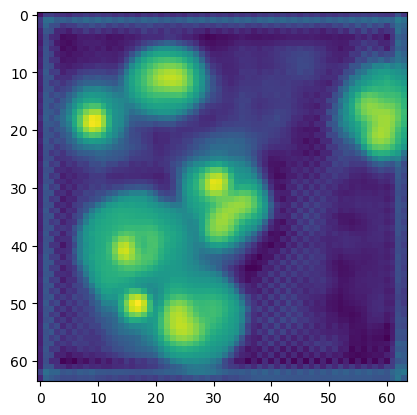

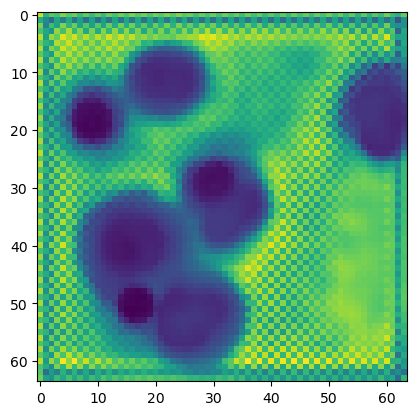

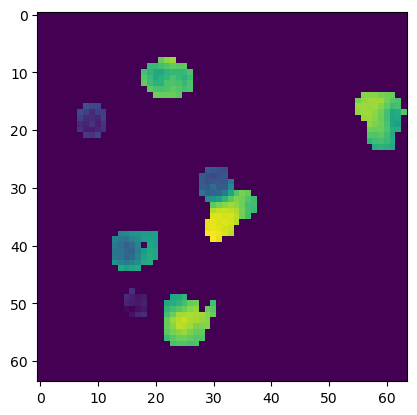

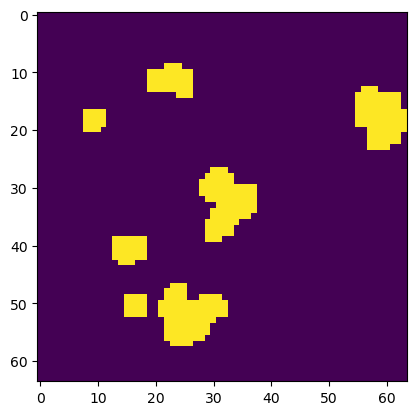

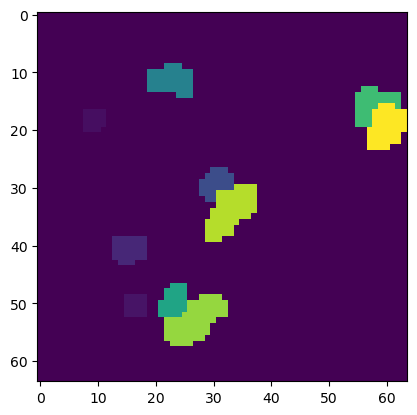

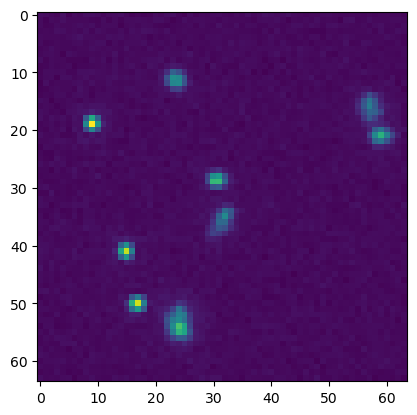

In [23]:
import matplotlib.pyplot as plt
plt.imshow(out1.detach().cpu().numpy())
plt.show()
plt.imshow(out2[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(results[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(in1[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(in2[:,:].detach().cpu().numpy()*in1[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(img[:,:].detach().cpu().numpy())

In [37]:
filename_m = dir_mask + 'mask_1.jpg'
mask = Image.open(filename_m)
mask2.max

<function Tensor.max>

In [12]:
wandb.finish()

Diffusion_loss,▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▁▂▃▄▄▃█
Validation Diffusion Loss,▄▁█▃
Validation Mask Loss,█▄▁▃
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,▁▁▁▁
mask_loss,██▇▇▆▆▅▅▅▄▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▃▂▂▄▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Diffusion_loss,1.68815
Validation Diffusion Loss,0.17143
Validation Mask Loss,0.13013
epoch,1


In [14]:
from PIL import Image
filename = './data/imgs/0cdf5b5d0ce1_01.jpg'
img = Image.open(filename)

img2 = torch.from_numpy(BasicDataset.preprocess(None, img, 1, is_mask=False))

In [19]:
filename_m = './data/masks/fff9b3a5373f_14_mask.gif'
mask = Image.open(filename_m)
mask2 = torch.from_numpy(BasicDataset.preprocess([0,1], img, 1, is_mask=True))

In [20]:
mask2

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])